# Python tutorial with multiprocessing

In [1]:
import numpy as np
import numpy.ma as ma
import PySeqArray as ps
import pandas
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import types

%matplotlib inline

Open an existing SeqArray file and display its structure. The dimensions of sample.id and variant.id tell you the total numbers of samples and variants, i.e., 1092 samples and 19,773 variants.

In [2]:
fn = ps.seqExample('1KG_phase1_release_v3_chr22.gds')
f = ps.SeqArrayFile()
f.open(fn)
f.show()

File: /Users/sts/anaconda/lib/python3.6/site-packages/PySeqArray/data/1KG_phase1_release_v3_chr22.gds (1.1M)
+    [  ] *
|--+ description   [  ] *
|--+ sample.id   { Str8 1092 LZMA_ra(10.5%), 914B } *
|--+ variant.id   { Int32 19773 LZMA_ra(8.39%), 6.5K } *
|--+ position   { Int32 19773 LZMA_ra(52.0%), 40.1K } *
|--+ chromosome   { Str8 19773 LZMA_ra(0.28%), 166B } *
|--+ allele   { Str8 19773 LZMA_ra(22.7%), 109.2K } *
|--+ genotype   [  ] *
|  |--+ data   { Bit2 19773x1092x2 LZMA_ra(8.17%), 861.8K } *
|  |--+ extra.index   { Int32 0x3 LZMA_ra, 19B } *
|  \--+ extra   { Int16 0 LZMA_ra, 19B }
|--+ phase   [  ]
|  |--+ data   { Bit1 19773x1092 LZMA_ra(0.02%), 550B } *
|  |--+ extra.index   { Int32 0x3 LZMA_ra, 19B } *
|  \--+ extra   { Bit1 0 LZMA_ra, 19B }
|--+ annotation   [  ]
|  |--+ id   { Str8 19773 LZMA_ra(35.2%), 75.2K } *
|  |--+ qual   { Float32 19773 LZMA_ra(3.62%), 2.8K } *
|  |--+ filter   { Int32,factor 19773 LZMA_ra(0.21%), 170B } *
|  |--+ info   [  ]
|  \--+ format   [

Genotypic data and annotations are stored in an array-oriented manner, providing efficient data access using the Python programming language. FilterSet() and GetData() can be used together to retrieve data for a selected set of samples from a defined genomic region. Apply() applies a user-defined function to array margins of genotypes and annotations.

## Calculation of Allele Frequencies

In [3]:
f.FilterReset()  # reset the filter

In [4]:
def CalcAF(geno):
    gm = ma.masked_array(geno==0, mask=geno==255)  # create a masked array with missing genotypes
    v = np.mean(gm, axis=(1,2))                    # gm is a 3D array
    v.data[v.mask] = np.nan
    return(v.data)

f.Apply('genotype', CalcAF, as_is='unlist')

array([ 0.69505495,  0.94322344,  0.99954212, ...,  0.99679487,
        0.65842491,  0.91346154])

### Using 4 cores

In [5]:
def ParallelCalcAF(file, param):
    return file.Apply('genotype', CalcAF, as_is='unlist')

f.RunParallel(ParallelCalcAF, ncpu=4)

array([ 0.69505495,  0.94322344,  0.99954212, ...,  0.99679487,
        0.65842491,  0.91346154])

## Principal Component Analysis

In [6]:
def PCA(val, geno):
    gm = ma.masked_array(geno, geno==255)             # create a masked array with missing genotypes
    p = np.mean(gm, axis=1).data * 0.5                # allele frequencies (a vector)
    g = np.array(geno, 'double')
    g = (g.transpose() - 2*p) / np.sqrt(p * (1 - p))  # normalized by allele frequency
    g[np.isnan(g)] = 0                                # correct missing values
    g[gm.mask.transpose()] = 0
    val.cov = val.cov + np.matmul(g, g.transpose())   # update the cov matrix

### Using 4 cores

In [7]:
def ParallelPCA(file, param):
    s = types.SimpleNamespace(cov=0)
    file.Apply('$dosage', PCA, s)
    return s.cov

mat = f.RunParallel(ParallelPCA, ncpu=2, combine=(lambda x,y: x+y))

/Users/sts/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in true_divide
/Users/sts/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in true_divide


In [8]:
cov = mat * (mat.shape[0] / sum(np.diag(mat)))
cov

array([[ 0.70169957,  0.00830316,  0.05113733, ...,  0.01978629,
         0.05134734,  0.012317  ],
       [ 0.00830316,  0.62280866,  0.03326604, ...,  0.02716621,
         0.02789678,  0.02354706],
       [ 0.05113733,  0.03326604,  0.77340245, ...,  0.01013458,
         0.03042339,  0.02440108],
       ..., 
       [ 0.01978629,  0.02716621,  0.01013458, ...,  0.92201769,
         0.02244575,  0.01091362],
       [ 0.05134734,  0.02789678,  0.03042339, ...,  0.02244575,
         0.63179936,  0.00977053],
       [ 0.012317  ,  0.02354706,  0.02440108, ...,  0.01091362,
         0.00977053,  0.97954933]])

In [9]:
w, v = np.linalg.eig(cov)
w  # eigenvalues

array([ 39.60517218,  16.51956609,   5.18983317, ...,   0.52165852,
         0.51818269,   0.55006929])

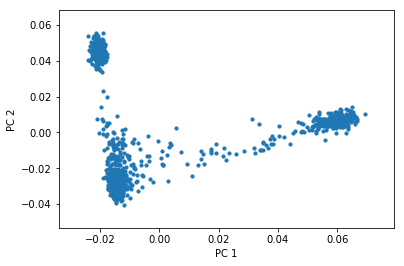

In [10]:
plt.scatter(v[:,0], v[:,1], s=10)
plt.xlabel('PC 1')
plt.ylabel('PC 2')